## CaOH MOT force profiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time

In [2]:
start = time.time()

Gamma = 6.4 # MHz
bFX=2.602
cX=2.053

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    N=1, Lambda=0, B=0, b=(bFX-cX/3)/Gamma, c=2.053/Gamma,
    cc=0/Gamma, gamma=34.7593/Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
# H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
#     N=1, Lambda=0, B=0, b=(bFX-cX/3)/Gamma, c=2.053/Gamma,
#     cc=0/Gamma, gamma=100.0/Gamma,
#     muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
#     )
E_X = np.unique(np.diag(H0_X))
H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=0/Gamma, q=0, p=0, gJ=2*-0.021,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I1=1/2, S=1/2, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq)

In [3]:
omega = 2*np.pi*(cts.c/626e-9)
k = 1e-6/(626e-9) #MHz/(m/s)
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)
#print("I_sat = ", Isat*1e-4*1e3)

# Make the magnetic field (2 G/mm):
magField = pylcp.quadrupoleMagneticField(2)

# A litle helper function to make the MOT:
def six_beam_CaF_MOT(svec, detvec, polvec, waistvec):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        laserBeams += pylcp.conventional3DMOTBeams(
            s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii], wb=waistvec[ii],
            beam_type=pylcp.gaussianBeam
            )
#         laserBeams += pylcp.conventional3DMOTBeams(
#             s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii],
#             beam_type=pylcp.infinitePlaneWaveBeam
#             )

    return laserBeams

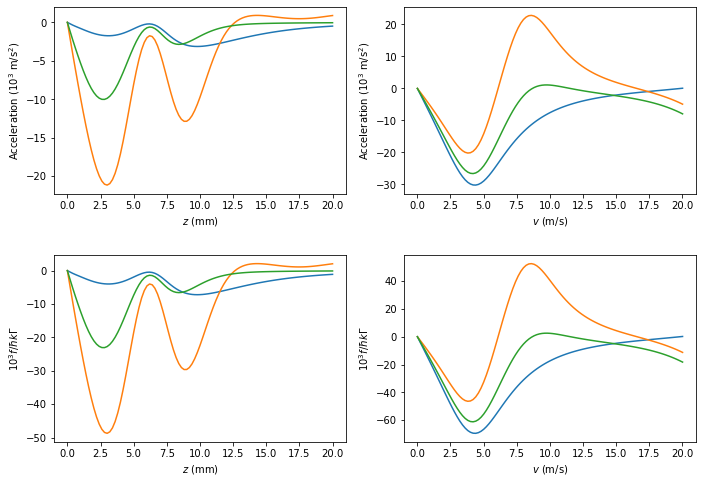

In [4]:
# MOT parameters
waist = np.array([8*np.ones(4), 8*np.ones(4), 8*np.ones(4)])*1e-3 #m, 1/e^2 waist
detvec = np.array([[-1, -1, -1, -1],
                   [+2, -1, +2, -1],
                  [+2, -1, +2, -1]])
Pvec = 0.2*np.array([[0.0, 0.5, 0.0, 0.5],
                     [0.25, 0.25, 0.25, 0.25],
                    [0.0, 0.33, 0.33, 0.34]])
intensities = 2.*Pvec/(np.pi*waist**2)/Isat
polvec = np.array([[-1.0, 1.0, 1.0, -1.0],
                   [-1.0, 1.0, 1.0, -1.0],
                  [-1.0, 1.0, 1.0, -1.0]])

# Make the axis:
z = np.linspace(1e-10, 20., 101)
v = np.linspace(0., 5., 101)

# Start the figure:
fig, ax = plt.subplots(2, 2, figsize=(11.5, 8), num="Forces in CaF MOT")
for ii in range(np.size(detvec,0)):
    laserBeams = six_beam_CaF_MOT(intensities[ii,:], detvec[ii,:], polvec[ii,:], waist[ii,:])
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[0,0].plot(z, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fz'].F[2], color='C{0:d}'.format(ii))
    ax[0,1].plot(v*Gamma/k, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fv'].F[2], color='C{0:d}'.format(ii))
    ax[1,0].plot(z, 1e3*trap.profile['Fz'].F[2], color='C{0:d}'.format(ii))
    ax[1,1].plot(v*Gamma/k, 1e3*trap.profile['Fv'].F[2], color='C{0:d}'.format(ii))

for ax_i in ax[0,:]:
    ax_i.set_ylabel('Acceleration ($10^3$ m/s$^2$)')
for ax_i in ax[1,:]:
    ax_i.set_ylabel('$10^3 f/\hbar k \Gamma$')

for ax_i in ax[:, 0]:
    ax_i.set_xlabel('$z$ (mm)')
for ax_i in ax[:, 1]:
    ax_i.set_xlabel('$v$ (m/s)')

fig.subplots_adjust(hspace=0.33, wspace=0.2)

### Simulating MOT capture

Using code from pylcp example documentation

In [5]:
# MOT parameters
waist = np.array([8*np.ones(4), 8*np.ones(4)])*1e-3 #m, 1/e^2 waist
detvec = np.array([[-1, -1, -1, -1],
                   [+2, -1, +2, -1]])
Pvec = 0.2*np.array([[0.0, 0.5, 0.0, 0.5],
                     [0.25, 0.25, 0.25, 0.25]])
intensities = 2.*Pvec/(np.pi*waist**2)/Isat
polvec = np.array([[-1.0, 1.0, 1.0, -1.0],
                   [-1.0, 1.0, 1.0, -1.0]])

In [6]:
#calculating z-v phase space for first configuration above
laserBeams = six_beam_CaF_MOT(intensities[0,:], detvec[0,:], polvec[0,:], waist[0,:])
trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

ep = 0.1
dz = 0.5
dv = 0.1
z = np.arange(-20+ep, 20+dz+ep, dz)
v = np.arange(-5, 5+dv, dv)

Z, V = np.meshgrid(z, v)

Rfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z])
Vfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), V])

trap.generate_force_profile([np.zeros(Z.shape), np.zeros(Z.shape), Z],
                           [np.zeros(V.shape), np.zeros(V.shape), V],
                           name='Fz', progress_bar=True);

Completed in 12.79 s.                                               


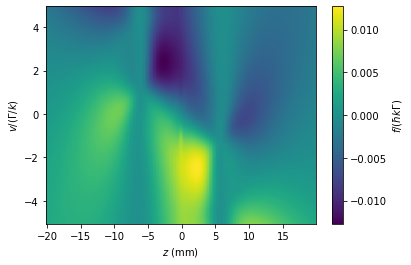

In [7]:
fig, ax = plt.subplots(1, 1)
plt.imshow(trap.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z$ (mm)')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

In [8]:
v0s = np.arange(0.1, 1, 0.1)

# See solve_ivp documentation for event function discussion:
# y[-6:-1] is (vx, vy, vz, x, y, z)
def captured_condition(t, y, threshold=1e-5):
    if(y[-4]<threshold and y[-1]<1e-3):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-1]>20.:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

init_pop = np.concatenate((1/12*np.ones(12),np.zeros(4))) #equal population in ground states, no population in excited states
sols = []
for v0 in v0s:
    trap.set_initial_position_and_velocity(np.array([0., 0., z[0]]),
                                          np.array([0., 0., v0]))
    if isinstance(trap, pylcp.rateeq):
        trap.set_initial_pop(init_pop)

    trap.evolve_motion([0., 100.], events=[captured_condition, lost_condition], max_step=0.1, progress_bar = True)

    sols.append(trap.sol)

Completed in 11.48 s.                                               
Completed in 11.51 s.                                               
Completed in 11.24 s.                                               
Completed in 11.75 s.                                               
Completed in 11.84 s.                                               
Completed in 11.89 s.                                               
Completed in 12.36 s.                                               
Completed in 13.70 s.                                               
Completed in 12.09 s.                                               


fig, ax = plt.subplots(1, 1)
plt.imshow(trap.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z$ (mm)')
ax.set_ylabel('$v/(\Gamma/k)$')

fig.subplots_adjust(left=0.15, right=0.91, bottom=0.2)

for sol in sols:
    ax.plot(sol.r[2], sol.v[2], 'w-', linewidth=0.375)

#ax.yaxis.set_ticks([-5, 0, 5])
# Display the figure at the end of the thing.
ax.set_xlim((-20, 20))
ax.set_xlim((-20, 20));

In [9]:
v0s*Gamma/k

array([0.40064, 0.80128, 1.20192, 1.60256, 2.0032 , 2.40384, 2.80448,
       3.20512, 3.60576])

In [10]:
#calculating z-v phase space for 2nd configuration above
laserBeams = six_beam_CaF_MOT(intensities[1,:], detvec[1,:], polvec[1,:], waist[1,:])
trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

ep = 0.1
dz = 0.5
dv = 0.1
z = np.arange(-20+ep, 20+dz+ep, dz)
v = np.arange(-5, 5+dv, dv)

Z, V = np.meshgrid(z, v)

Rfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z])
Vfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), V])

trap.generate_force_profile([np.zeros(Z.shape), np.zeros(Z.shape), Z],
                           [np.zeros(V.shape), np.zeros(V.shape), V],
                           name='Fz', progress_bar=True);

Completed in 12.32 s.                                               


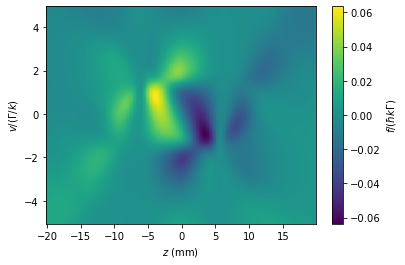

In [11]:
fig, ax = plt.subplots(1, 1)
plt.imshow(trap.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z$ (mm)')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

In [12]:
v0s = np.arange(0.1, 1, 0.1)

# See solve_ivp documentation for event function discussion:
# y[-6:-1] is (vx, vy, vz, x, y, z)
def captured_condition(t, y, threshold=1e-5):
    if(y[-4]<threshold and y[-1]<1e-3):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-1]>20.:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

init_pop = np.concatenate((1/12*np.ones(12),np.zeros(4))) #equal population in ground states, no population in excited states
sols = []
for v0 in v0s:
    trap.set_initial_position_and_velocity(np.array([0., 0., z[0]]),
                                          np.array([0., 0., v0]))
    if isinstance(trap, pylcp.rateeq):
        trap.set_initial_pop(init_pop)

    trap.evolve_motion([0., 100.], events=[captured_condition, lost_condition], max_step=0.1, progress_bar = True)

    sols.append(trap.sol)

Completed in 1.14 s.                                               
Completed in 6.06 s.                                               
Completed in 10.34 s.                                              
Completed in 9.31 s.                                               
Completed in 8.79 s.                                                
Completed in 9.62 s.                                                
Completed in 9.85 s.                                                
Completed in 13.06 s.                                               
Completed in 9.52 s.                                                


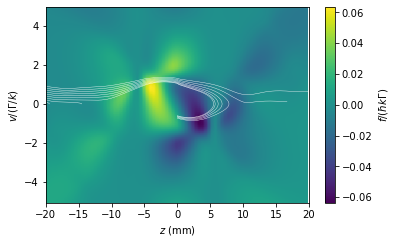

In [13]:
fig, ax = plt.subplots(1, 1)
plt.imshow(trap.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z$ (mm)')
ax.set_ylabel('$v/(\Gamma/k)$')

fig.subplots_adjust(left=0.15, right=0.91, bottom=0.2)

for sol in sols:
    ax.plot(sol.r[2], sol.v[2], 'w-', linewidth=0.375)

#ax.yaxis.set_ticks([-5, 0, 5])
# Display the figure at the end of the thing.
ax.set_xlim((-20, 20))
ax.set_xlim((-20, 20));

In [14]:
for sol in sols:
    if len(sol.t_events[0]) == 1:
        print('captured')
    elif len(sol.t_events[1]) == 1:
        print('lost')
    else:
        print('unknown')

captured
captured
captured
captured
captured
captured
captured
unknown
lost


In [15]:
def iscaptured(v0, z0, eqn, captured_condition, lost_condition, tmax=1000, max_step=0.1, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([0., 0., z0]),
                                          np.array([0., 0., v0]))
    eqn.evolve_motion([0., tmax], events=[captured_condition, lost_condition],
                      max_step=max_step)

    if len(eqn.sol.t_events[0]) == 1:
        return +1.
    else:
        return -1.

iscaptured(0.5, z[0], trap, captured_condition, lost_condition, tmax = 100)

1.0

In [16]:
from scipy.optimize import bisect #For root finding
import time

In [17]:
tic = time.perf_counter()
vcout = bisect(iscaptured, 0.1, 1.,
       args=(z[0], trap, captured_condition, lost_condition),
       xtol=0.25, rtol=1e-4, full_output=False
      )
toc = time.perf_counter()
toc-tic

29.464790800000003

In [18]:
vcout

0.775

In [19]:
# vcout[0]

## Define a function to spit out capture velocity vs. parameters

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
from scipy.optimize import bisect #For root finding
import time

In [21]:
Gamma = 6.4 # MHz
bFX=2.602
cX=2.053

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    N=1, Lambda=0, B=0, b=(bFX-cX/3)/Gamma, c=2.053/Gamma,
    cc=0/Gamma, gamma=34.7593/Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
# H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
#     N=1, Lambda=0, B=0, b=(bFX-cX/3)/Gamma, c=2.053/Gamma,
#     cc=0/Gamma, gamma=100.0/Gamma,
#     muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
#     )
E_X = np.unique(np.diag(H0_X))
H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=0/Gamma, q=0, p=0, gJ=2*-0.021,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I1=1/2, S=1/2, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq)

omega = 2*np.pi*(cts.c/626e-9)
k = 1e-6/(626e-9) #MHz/(m/s)
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)

# A litle helper function to make the MOT:
def six_beam_CaF_MOT(svec, detvec, polvec, waistvec):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        laserBeams += pylcp.conventional3DMOTBeams(
            s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii], wb=waistvec[ii],
            beam_type=pylcp.gaussianBeam
            )
#         laserBeams += pylcp.conventional3DMOTBeams(
#             s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii],
#             beam_type=pylcp.infinitePlaneWaveBeam
#             )

    return laserBeams

In [22]:
def vc_full_bayesian(Bgrad, w0, det1, det2, det3, det4, p1, p2, p3, p4, pol1, pol2, pol3, pol4):
    '''
    spits out capture velocity given the following MOT parameters:
    Bgrad: gradient in G/cm
    w0: 1/e^2 waist, in mm
    det1..4: detuning (units of Gamma) of beams 1-4. Detunings referenced to the four hyperfine levels, from low to high energy
    p1...4: fractional power of beams 1-4. These are normalized in the code, since the optimization will not constrain them to sum to 1
    pol1..4: polarization of beams 1-4. Runs from 0-1. Rounded in code so [0,0.5] is sigma-, [0.5,1] is sigma+
    '''
    
    laserpower = 200 #mW
    
    # Make the magnetic field (2 G/mm):
    magField = pylcp.quadrupoleMagneticField(Bgrad*0.1)
    
    # MOT parameters
    waist = w0*np.ones(4)*1e-3 #m, 1/e^2 waist
    detvec = np.array([det1, det2, det3, det4])
    Pvec = 1e-3*laserpower*np.array([p1, p2, p3, p4])/sum([p1,p2,p3,p4])
    intensities = 2.*Pvec/(np.pi*waist**2)/Isat
    polvec = 2*np.round(np.array([pol1, pol2, pol3, pol4]))-1
    
    laserBeams = six_beam_CaF_MOT(intensities, detvec, polvec, waist)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

    # See solve_ivp documentation for event function discussion:
    # y[-6:-1] is (vx, vy, vz, x, y, z)
    def captured_condition(t, y, threshold=1e-5):
        if(y[-4]<threshold and y[-1]<1e-3):
            val = -1.
        else:
            val = 1.

        return val

    def lost_condition(t, y, threshold=1e-5):
        if y[-1]>20.:
            val = -1.
        else:
            val = 1.

        return val

    captured_condition.terminal=True
    lost_condition.terminal=True

    init_pop = np.concatenate((1/12*np.ones(12),np.zeros(4))) #equal population in ground states, no population in excited states
    if isinstance(trap, pylcp.rateeq):
        trap.set_initial_pop(init_pop)
        
    def iscaptured(v0, z0, eqn, captured_condition, lost_condition, tmax=1000, max_step=0.1, **kwargs):
        eqn.set_initial_position_and_velocity(np.array([0., 0., z0]),
                                              np.array([0., 0., v0]))
        eqn.evolve_motion([0., tmax], events=[captured_condition, lost_condition],
                          max_step=max_step)

        if len(eqn.sol.t_events[0]) == 1:
            return +1.
        else:
            return -1.
    
    try: 
        vcout = bisect(iscaptured, 0.1, 5.,
           args=(z[0], trap, captured_condition, lost_condition),
           xtol=0.25, rtol=1e-4, full_output=False
          )
    except ValueError:
        print('ValueError encountered, assuming capture velocity is zero')
        vcout = 0.
    
    return vcout

In [23]:
from bayes_opt import BayesianOptimization

In [24]:
# Bounded region of parameter space
detmin = -10.
detmax = 10.
pbounds = {'Bgrad': (5., 30.), 'w0': (4., 15.), 'det1': (detmin, detmax), 'det2': (detmin, detmax), 'det3': (detmin, detmax), 'det4': (detmin, detmax),
              'p1': (0., 1.), 'p2': (0., 1.), 'p3': (0., 1.), 'p4': (0., 1.), 'pol1': (0., 1.), 'pol2': (0., 1.), 'pol3': (0., 1.), 'pol4': (0., 1.)}

optimizer = BayesianOptimization(
    f=vc_full_bayesian,
    pbounds=pbounds,
    random_state=1,
)

In [25]:
optimizer.maximize(
    init_points=10,
    n_iter=10,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5594   |  15.43    |  4.406    | -9.998    | -3.953    | -7.065    |  0.09234  |  0.1863   |  0.3456   |  0.3968   |  0.5388   |  0.4192   |  0.6852   |  0.2045   |  13.66    |
|  2        |  0.2531   |  5.685    |  3.409    | -1.654    |  1.174    | -7.192    |  0.1981   |  0.8007   |  0.9683   |  0.3134   |  0.6923   |  0.8764   |  0.8946   |  0.08504  |  4.43     |
|  3        |  0.5594   |  9.246    |  7.563    | -8.033    | -1.578    |  9.158    |  0.5332   |  0.6919   |  0.3155   |  0.6865   |  0.8346   |  0.01829  |  0.7501   |  0.9889   |  12.23    |
|  4        |  0.8656   |  12.

In [26]:
optimizer.maximize(
    init_points=20,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  21       |  0.8656   |  18.91    | -7.271    | -8.802    | -7.573    | -9.109    |  0.1075   |  0.2257   |  0.713    |  0.5597   |  0.01256  |  0.07197  |  0.9673   |  0.5681   |  6.236    |
|  22       |  0.5594   |  11.31    |  4.877    | -6.091    |  1.627    |  9.4      |  0.8468   |  0.2398   |  0.4938   |  0.62     |  0.829    |  0.1568   |  0.01858  |  0.07002  |  9.35     |
|  23       |  0.2531   |  20.16    |  1.377    | -3.653    |  9.772    |  1.595    |  0.3801   |  0.5509   |  0.7453   |  0.6692   |  0.2649   |  0.06633  |  0.3701   |  0.6297   |  6.312    |
|  24       |  0.2531   |  23.

In [27]:
optimizer.maximize(
    init_points=10,
    n_iter=20,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  141      |  0.2531   |  8.586    | -8.432    | -9.633    | -8.666    | -0.8283   |  0.1133   |  0.02778  |  0.7549   |  0.3949   |  0.7469   |  0.4524   |  0.4501   |  0.4781   |  9.214    |
|  142      |  0.2531   |  25.08    | -1.952    |  8.094    | -9.259    |  5.477    |  0.1256   |  0.6185   |  0.01036  |  0.5386   |  0.003018 |  0.9512   |  0.9054   |  0.796    |  14.07    |
|  143      |  0.2531   |  8.639    | -6.845    | -6.247    |  2.45     |  8.116    |  0.99     |  0.7111   |  0.7318   |  0.9093   |  0.4009   |  0.2499   |  0.1734   |  0.1195   |  12.94    |
|  144      |  1.172    |  8.6

In [28]:
optimizer.maximize(
    init_points=5,
    n_iter=50,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ValueError encountered, assuming capture velocity is zero
|  171      |  0.0      |  5.573    |  0.3816   |  6.2      | -9.748    |  3.449    |  0.6868   |  0.4492   |  0.9148   |  0.6444   |  0.00524  |  0.4844   |  0.8593   |  0.8304   |  11.14    |
|  172      |  0.5594   |  21.84    |  1.57     | -4.518    |  1.211    |  3.435    |  0.3524   |  0.8558   |  0.195    |  0.7473   |  0.2896   |  0.7738   |  0.4277   |  0.8077   |  7.889    |
ValueError encountered, assuming capture velocity is zero
|  173      |  0.0      |  10.34    |  5.346    | -3.827    |  4.665    |  4.889    |  0.2214   |  0.2141   

In [29]:
optimizer.maximize(
    init_points=20,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  226      |  0.8656   |  12.39    |  4.632    |  8.906    | -1.489    |  5.644    |  0.05614  |  0.8353   |  0.1923   |  0.3951   |  0.3001   |  0.0801   |  0.9046   |  0.3702   |  9.838    |
ValueError encountered, assuming capture velocity is zero
|  227      |  0.0      |  17.35    | -7.357    | -5.871    | -8.476    |  0.1584   |  0.2615   |  0.3571   |  0.1081   |  0.7876   |  0.1066   |  0.9857   |  0.1772   |  0.5724   |  4.493    |
|  228      |  0.8656   |  24.68    | -6.208    |  0.5581   |  4.802    | -7.001    |  0.5511   |  0.2166   |  0.7592   |  0.7229   |  0.1765   |  0.862    |  0.01978

In [30]:
optimizer.maximize(
    init_points=20,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  346      |  0.2531   |  19.28    | -6.391    |  2.619    |  9.618    |  7.498    |  0.4518   |  0.7085   |  0.7775   |  0.4948   |  0.5285   |  0.1508   |  0.3694   |  0.1422   |  12.0     |
|  347      |  0.5594   |  16.93    | -1.022    |  7.72     |  0.5524   | -1.818    |  0.2689   |  0.07201  |  0.4181   |  0.02575  |  0.2912   |  0.5035   |  0.9659   |  0.1094   |  11.4     |
ValueError encountered, assuming capture velocity is zero
|  348      |  0.0      |  17.5     |  5.542    | -7.128    | -8.336    | -2.016    |  0.797    |  0.1917   |  0.7678   |  0.2903   |  0.2169   |  0.01672  |  0.3987 

In [31]:
optimizer.maximize(
    init_points=0,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  466      |  1.784    |  9.183    |  0.6307   | -1.159    | -1.274    |  8.169    |  0.7263   |  0.2952   |  0.8557   |  0.3865   |  0.2697   |  0.5836   |  0.264    |  0.5039   |  8.637    |
|  467      |  0.5594   |  9.524    | -4.814    |  0.8773   | -2.359    | -6.095    |  0.5649   |  0.2567   |  0.2106   |  0.5815   |  0.5073   |  0.6338   |  0.9465   |  0.06446  |  10.19    |
|  468      |  0.8656   |  10.32    | -0.03195  | -3.014    | -1.722    |  8.619    |  0.6351   |  0.7747   |  0.2928   |  0.4507   |  0.7103   |  0.2868   |  0.9823   |  0.359    |  8.798    |
ValueError encountered, assumi

In [32]:
optimizer.maximize(
    init_points=0,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  566      |  0.2531   |  13.35    |  0.2659   |  0.06761  | -1.562    | -6.908    |  0.7259   |  0.6484   |  0.454    |  0.516    |  0.6375   |  0.6499   |  0.8244   |  0.05323  |  4.494    |
|  567      |  0.2531   |  10.31    | -0.1854   | -3.742    | -0.1842   |  8.46     |  0.7365   |  0.7685   |  0.8733   |  0.4493   |  0.6016   |  0.5578   |  0.1146   |  0.5952   |  9.669    |
|  568      |  1.172    |  8.937    |  1.115    |  0.0369   | -1.059    |  7.663    |  0.2304   |  0.3922   |  0.3659   |  0.8988   |  0.6103   |  0.4046   |  0.8364   |  0.2215   |  9.367    |
|  569      |  1.784    |  10.

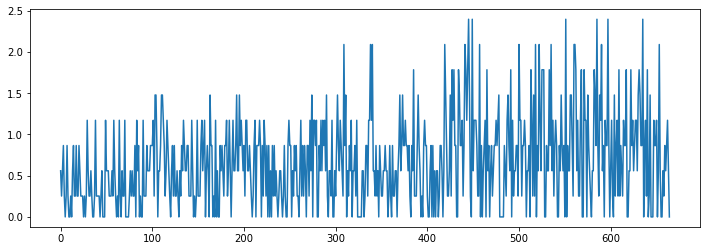

In [33]:
targets = np.zeros(len(optimizer.res))
for i, res in enumerate(optimizer.res):
    targets[i] = res['target']
    
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(targets)

In [34]:
maxtarget = np.amax(targets)
print(maxtarget)
maxinds = np.where(targets == maxtarget)
print(maxinds)

2.3968750000000005
(array([445, 449, 551, 585, 597, 635], dtype=int64),)


In [35]:
for i in maxinds[0]:
    print("Iteration {}: \n\t{}".format(i, optimizer.res[i]))

Iteration 445: 
	{'target': 2.3968750000000005, 'params': {'Bgrad': 8.7933772494375, 'det1': -0.7661915649280644, 'det2': -2.6482438984037255, 'det3': -1.2680947168118184, 'det4': 9.517575080902176, 'p1': 0.6231280570743929, 'p2': 0.6919086138702364, 'p3': 0.8614439666760654, 'p4': 0.40723854496682244, 'pol1': 0.9464228362518178, 'pol2': 0.25595348461938483, 'pol3': 0.5561824436894015, 'pol4': 0.4767740801419177, 'w0': 6.158995114034214}}
Iteration 449: 
	{'target': 2.3968750000000005, 'params': {'Bgrad': 12.738770349724664, 'det1': 0.5056149953963276, 'det2': -1.246882645394967, 'det3': -1.7254278422236167, 'det4': -7.03520354195273, 'p1': 0.3656499315306491, 'p2': 0.48295159511608465, 'p3': 0.5294944719931439, 'p4': 0.6739064605615472, 'pol1': 0.3671377901161906, 'pol2': 0.6753038244487968, 'pol3': 0.27476193466695775, 'pol4': 0.808588328843807, 'w0': 4.192832504789359}}
Iteration 551: 
	{'target': 2.3968750000000005, 'params': {'Bgrad': 7.095014800802403, 'det1': -1.0793783590890804

## Bayesian optimization of capture velocity coming in from x direction

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
from scipy.optimize import bisect #For root finding
import time

In [37]:
Gamma = 6.4 # MHz
bFX=2.602
cX=2.053

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    N=1, Lambda=0, B=0, b=(bFX-cX/3)/Gamma, c=2.053/Gamma,
    cc=0/Gamma, gamma=34.7593/Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
# H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
#     N=1, Lambda=0, B=0, b=(bFX-cX/3)/Gamma, c=2.053/Gamma,
#     cc=0/Gamma, gamma=100.0/Gamma,
#     muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
#     )
E_X = np.unique(np.diag(H0_X))
H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=0/Gamma, q=0, p=0, gJ=2*-0.021,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I1=1/2, S=1/2, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq)

omega = 2*np.pi*(cts.c/626e-9)
k = 1e-6/(626e-9) #MHz/(m/s)
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)

# A litle helper function to make the MOT:
def six_beam_CaF_MOT(svec, detvec, polvec, waistvec):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        laserBeams += pylcp.conventional3DMOTBeams(
            s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii], wb=waistvec[ii],
            beam_type=pylcp.gaussianBeam
            )
#         laserBeams += pylcp.conventional3DMOTBeams(
#             s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii],
#             beam_type=pylcp.infinitePlaneWaveBeam
#             )

    return laserBeams

In [38]:
def vc_full_bayesian_x(Bgrad, w0, det1, det2, det3, det4, p1, p2, p3, p4, pol1, pol2, pol3, pol4):
    '''
    spits out capture velocity given the following MOT parameters:
    Bgrad: gradient in G/cm
    w0: 1/e^2 waist, in mm
    det1..4: detuning (units of Gamma) of beams 1-4. Detunings referenced to the four hyperfine levels, from low to high energy
    p1...4: fractional power of beams 1-4. These are normalized in the code, since the optimization will not constrain them to sum to 1
    pol1..4: polarization of beams 1-4. Runs from 0-1. Rounded in code so [0,0.5] is sigma-, [0.5,1] is sigma+
    '''
    
    laserpower = 200 #mW
    
    # Make the magnetic field (2 G/mm):
    magField = pylcp.quadrupoleMagneticField(Bgrad*0.1)
    
    # MOT parameters
    waist = w0*np.ones(4)*1e-3 #m, 1/e^2 waist
    detvec = np.array([det1, det2, det3, det4])
    Pvec = 1e-3*laserpower*np.array([p1, p2, p3, p4])/sum([p1,p2,p3,p4])
    intensities = 2.*Pvec/(np.pi*waist**2)/Isat
    polvec = 2*np.round(np.array([pol1, pol2, pol3, pol4]))-1
    
    laserBeams = six_beam_CaF_MOT(intensities, detvec, polvec, waist)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

    # See solve_ivp documentation for event function discussion:
    # y[-6:-1] is (vx, vy, vz, x, y, z)
    def captured_condition(t, y, threshold=1e-5):
        if(y[-6]<threshold and y[-3]<1e-3):
            val = -1.
        else:
            val = 1.

        return val

    def lost_condition(t, y, threshold=1e-5):
        if y[-3]>20.:
            val = -1.
        else:
            val = 1.

        return val

    captured_condition.terminal=True
    lost_condition.terminal=True

    init_pop = np.concatenate((1/12*np.ones(12),np.zeros(4))) #equal population in ground states, no population in excited states
    if isinstance(trap, pylcp.rateeq):
        trap.set_initial_pop(init_pop)
        
    def iscaptured(v0, z0, eqn, captured_condition, lost_condition, tmax=1000, max_step=0.1, **kwargs):
        eqn.set_initial_position_and_velocity(np.array([z0, 0., 0.]),
                                              np.array([v0, 0., 0.]))
        eqn.evolve_motion([0., tmax], events=[captured_condition, lost_condition],
                          max_step=max_step)

        if len(eqn.sol.t_events[0]) == 1:
            return +1.
        else:
            return -1.
    
    z0 = -25. #initial position
    
    try: 
        vcout = bisect(iscaptured, 0.1, 5.,
           args=(z0, trap, captured_condition, lost_condition),
           xtol=0.25, rtol=1e-4, full_output=False
          )
    except ValueError:
        print('ValueError encountered, assuming capture velocity is zero')
        vcout = 0.
    
    return vcout

In [39]:
vc_full_bayesian(7, 6.6, -2.8, -0.1, 3.3, -1.9, 0.97, 0.13, 0.02, 0.71, 1., 0., 1., 0.) #z direction

2.3968750000000005

In [40]:
vc_full_bayesian_x(7, 6.6, -2.8, -0.1, 3.3, -1.9, 0.97, 0.13, 0.02, 0.71, 1., 0., 1., 0.)

2.7031250000000004

In [41]:
vc_full_bayesian_x(20, 8, 2., -1., 2., -1, 0.25, 0.25, 0.25, 0.25, 0., 1., 1., 0.)

0.559375

In [42]:
from bayes_opt import BayesianOptimization

In [43]:
# Bounded region of parameter space
detmin = -10.
detmax = 10.
pbounds = {'Bgrad': (5., 30.), 'w0': (4., 15.), 'det1': (detmin, detmax), 'det2': (detmin, detmax), 'det3': (detmin, detmax), 'det4': (detmin, detmax),
              'p1': (0., 1.), 'p2': (0., 1.), 'p3': (0., 1.), 'p4': (0., 1.), 'pol1': (0., 1.), 'pol2': (0., 1.), 'pol3': (0., 1.), 'pol4': (0., 1.)}

optimizer_x = BayesianOptimization(
    f=vc_full_bayesian_x,
    pbounds=pbounds,
    random_state=1,
)

In [44]:
optimizer_x.maximize(
    init_points=30,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.2531   |  15.43    |  4.406    | -9.998    | -3.953    | -7.065    |  0.09234  |  0.1863   |  0.3456   |  0.3968   |  0.5388   |  0.4192   |  0.6852   |  0.2045   |  13.66    |
ValueError encountered, assuming capture velocity is zero
|  2        |  0.0      |  5.685    |  3.409    | -1.654    |  1.174    | -7.192    |  0.1981   |  0.8007   |  0.9683   |  0.3134   |  0.6923   |  0.8764   |  0.8946   |  0.08504  |  4.43     |
|  3        |  0.5594   |  9.246    |  7.563    | -8.033    | -1.578    |  9.158    |  0.5332   |  0.6919   |  0.3155   |  0.6865   |  0.8346   |  0.01829  |  0.7501 

In [45]:
optimizer_x.maximize(
    init_points=30,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  131      |  0.5594   |  8.586    | -8.432    | -9.633    | -8.666    | -0.8283   |  0.1133   |  0.02778  |  0.7549   |  0.3949   |  0.7469   |  0.4524   |  0.4501   |  0.4781   |  9.214    |
|  132      |  0.2531   |  25.08    | -1.952    |  8.094    | -9.259    |  5.477    |  0.1256   |  0.6185   |  0.01036  |  0.5386   |  0.003018 |  0.9512   |  0.9054   |  0.796    |  14.07    |
|  133      |  0.2531   |  8.639    | -6.845    | -6.247    |  2.45     |  8.116    |  0.99     |  0.7111   |  0.7318   |  0.9093   |  0.4009   |  0.2499   |  0.1734   |  0.1195   |  12.94    |
|  134      |  0.8656   |  8.6

In [46]:
optimizer_x.maximize(
    init_points=30,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  261      |  1.172    |  9.038    | -3.151    | -4.762    |  6.891    |  6.007    |  0.4266   |  0.607    |  0.1455   |  0.5096   |  0.2969   |  0.8597   |  0.6716   |  0.6335   |  5.372    |
ValueError encountered, assuming capture velocity is zero
|  262      |  0.0      |  16.76    |  9.731    |  8.966    |  2.902    | -6.966    |  0.6391   |  0.5657   |  0.4687   |  0.428    |  0.5993   |  0.85     |  0.7511   |  0.5794   |  14.17    |
|  263      |  0.2531   |  6.618    |  9.827    | -8.94     | -6.01     | -1.545    |  0.1075   |  0.6237   |  0.04799  |  0.2846   |  0.06104  |  0.7035   |  0.6685 

In [47]:
optimizer_x.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ValueError encountered, assuming capture velocity is zero
|  391      |  0.0      |  7.955    |  6.74     |  4.883    |  1.81     | -5.142    |  0.6232   |  0.6384   |  0.3276   |  0.06749  |  0.8805   |  0.46     |  0.7639   |  0.2539   |  10.51    |
|  392      |  0.8656   |  15.72    | -2.358    | -7.466    | -5.115    | -8.413    |  0.3029   |  0.7417   |  0.615    |  0.6724   |  0.008383 |  0.6784   |  0.5032   |  0.2309   |  5.924    |
|  393      |  0.8656   |  9.625    |  6.885    |  9.652    |  8.275    | -3.053    |  0.7802   |  0.5465   |  0.8164   |  0.4837   |  0.59     |  0.7873   |  0.1002 

In [48]:
optimizer_x.maximize(
    init_points=50,
    n_iter=100,
    alpha = 1e-2,
    normalize_y = True
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  541      |  0.2531   |  26.0     |  7.402    |  6.335    |  7.556    |  1.42     |  0.964    |  0.6065   |  0.6039   |  0.3193   |  0.6812   |  0.05197  |  0.1345   |  0.1302   |  11.21    |
|  542      |  0.8656   |  9.383    | -3.177    | -9.114    | -5.325    |  9.284    |  0.5091   |  0.1511   |  0.523    |  0.9435   |  0.8657   |  0.3921   |  0.2839   |  0.7617   |  6.645    |
|  543      |  0.2531   |  11.36    | -8.318    |  7.283    | -1.042    |  1.236    |  0.7367   |  0.7965   |  0.4475   |  0.1841   |  0.8287   |  0.031    |  0.9467   |  0.577    |  13.63    |
|  544      |  0.2531   |  20.

In [49]:
optimizer_x.maximize(
    init_points=20,
    n_iter=100
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  691      |  0.2531   |  12.7     |  1.739    | -2.091    |  3.279    |  7.039    |  0.1902   |  0.9033   |  0.3832   |  0.9431   |  0.6174   |  0.7901   |  0.5148   |  0.5311   |  7.604    |
ValueError encountered, assuming capture velocity is zero
|  692      |  0.0      |  8.234    | -2.324    | -5.7      | -9.343    | -4.502    |  0.1806   |  0.8755   |  0.08124  |  0.1839   |  0.704    |  0.9192   |  0.2515   |  0.0213   |  14.57    |
|  693      |  0.8656   |  22.06    | -3.787    | -0.5525   |  1.985    | -2.523    |  0.8745   |  0.7262   |  0.9543   |  0.3511   |  0.9372   |  0.4791   |  0.6423 

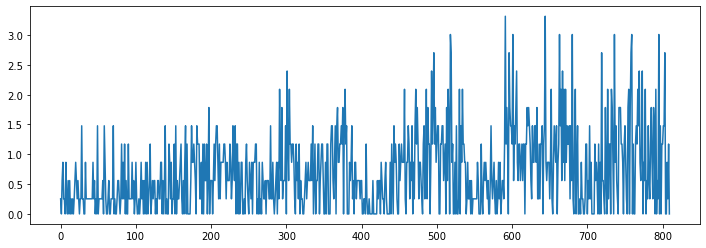

In [50]:
targets_x = np.zeros(len(optimizer_x.res))
for i, res in enumerate(optimizer_x.res):
    targets_x[i] = res['target']
    
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(targets_x)

In [51]:
maxtarget_x = np.amax(targets_x)
print(maxtarget_x)
maxinds_x = np.where(targets_x == maxtarget_x)
print(maxinds_x)

3.3156250000000007
(array([591, 644], dtype=int64),)


In [52]:
for i in maxinds_x[0]:
    print("Iteration {}: \n\t{}".format(i, optimizer_x.res[i]))

Iteration 591: 
	{'target': 3.3156250000000007, 'params': {'Bgrad': 12.306285191523502, 'det1': -0.3783910197484966, 'det2': -1.941684589761952, 'det3': -3.1511908139534186, 'det4': -5.41319931024068, 'p1': 0.7668260268145426, 'p2': 0.7185243515901988, 'p3': 0.7537774002277233, 'p4': 0.422445223237343, 'pol1': 0.9246780752867019, 'pol2': 0.44566131723658636, 'pol3': 0.3209880302668194, 'pol4': 0.511558829760833, 'w0': 4.581515612385159}}
Iteration 644: 
	{'target': 3.3156250000000007, 'params': {'Bgrad': 12.531814136321321, 'det1': -0.541257280135949, 'det2': -1.971581165674596, 'det3': -2.92785179878407, 'det4': -5.704174521001641, 'p1': 0.7283655383106887, 'p2': 0.7960464562453259, 'p3': 0.8054991554529196, 'p4': 0.4330281331040074, 'pol1': 0.903495711252799, 'pol2': 0.45187120635568845, 'pol3': 0.3120632968898633, 'pol4': 0.5728821279211773, 'w0': 4.639896803113615}}


## Plotting force profiles

In [53]:
def plot_force_profiles(Bgrad, w0, det1, det2, det3, det4, p1, p2, p3, p4, pol1, pol2, pol3, pol4):
    '''
    plots force profiles given the following MOT parameters:
    Bgrad: gradient in G/cm
    w0: 1/e^2 waist, in mm
    det1..4: detuning (units of Gamma) of beams 1-4. Detunings referenced to the four hyperfine levels, from low to high energy
    p1...4: fractional power of beams 1-4. These are normalized in the code, since the optimization will not constrain them to sum to 1
    pol1..4: polarization of beams 1-4. Runs from 0-1. Rounded in code so [0,0.5] is sigma-, [0.5,1] is sigma+
    '''
    
    laserpower = 200 #mW
    
    # Make the magnetic field (2 G/mm):
    magField = pylcp.quadrupoleMagneticField(Bgrad*0.1)
    
    # MOT parameters
    waist = w0*np.ones(4)*1e-3 #m, 1/e^2 waist
    detvec = np.array([det1, det2, det3, det4])
    Pvec = 1e-3*laserpower*np.array([p1, p2, p3, p4])/sum([p1,p2,p3,p4])
    intensities = 2.*Pvec/(np.pi*waist**2)/Isat
    polvec = 2*np.round(np.array([pol1, pol2, pol3, pol4]))-1
    
    laserBeams = six_beam_CaF_MOT(intensities, detvec, polvec, waist)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    
    # Make the axis:
    z = np.linspace(1e-10, 20., 101)
    v = np.linspace(0., 5., 101)
    
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    
    fig, ax = plt.subplots(1, 2, figsize=(11.5, 4), num="Forces in CaF MOT")
    ax[0].plot(z, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fz'].F[2], color='C{0:d}'.format(0))
    ax[1].plot(v*Gamma/k, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fv'].F[2], color='C{0:d}'.format(0))
    
    for ax_i in ax:
        ax_i.set_ylabel('Acceleration ($10^3$ m/s$^2$)')
    
    ax[0].set_xlabel('$z$ (mm)')
    ax[1].set_xlabel('$v$ (m/s)')
    
    fig.subplots_adjust(hspace=0.33, wspace=0.2)

In [54]:
optimizer.max

{'target': 2.3968750000000005,
 'params': {'Bgrad': 8.7933772494375,
  'det1': -0.7661915649280644,
  'det2': -2.6482438984037255,
  'det3': -1.2680947168118184,
  'det4': 9.517575080902176,
  'p1': 0.6231280570743929,
  'p2': 0.6919086138702364,
  'p3': 0.8614439666760654,
  'p4': 0.40723854496682244,
  'pol1': 0.9464228362518178,
  'pol2': 0.25595348461938483,
  'pol3': 0.5561824436894015,
  'pol4': 0.4767740801419177,
  'w0': 6.158995114034214}}

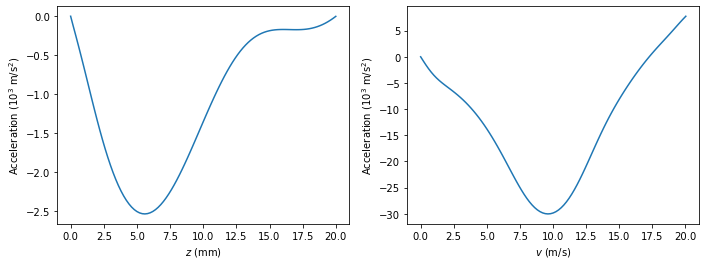

In [55]:
# optimal after 170 runs
plot_force_profiles(7, 6.6, -2.8, -0.1, 3.3, -1.9, 0.97, 0.13, 0.02, 0.71, 1., 0., 1., 0.)

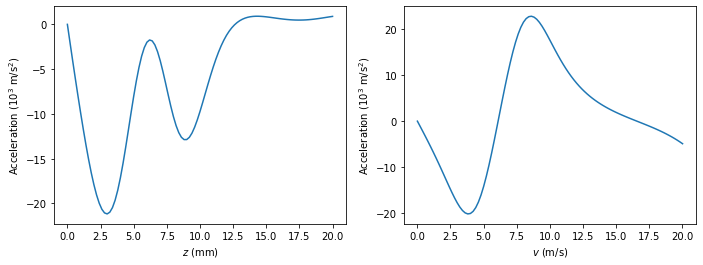

In [56]:
# "nominal" dual-frequency MOT
plot_force_profiles(20, 8, 2., -1., 2., -1, 0.25, 0.25, 0.25, 0.25, 0., 1., 1., 0.)

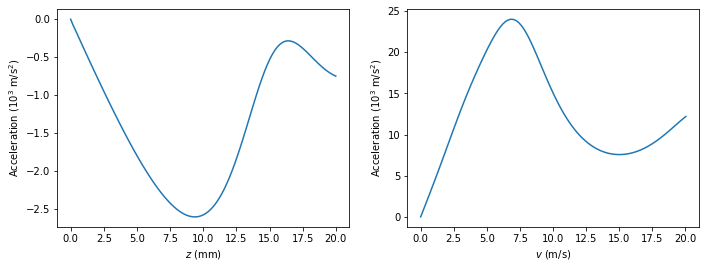

In [57]:
# a ValueError point (190)
plot_force_profiles(7.6, 12.6, 5.6, -7.4, 9.8, -6.3, 0.80, 0.88, 0.41, 0.70, 1.0, 1.0, 0., 1.)

In [58]:
print(time.time()-start)

129579.97723293304
